In [ ]:
%%capture
!pip install transformers einops jaxtyping colorama datasets scikit-learn tqdm

In [ ]:
%%capture
!pip install pandas

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch
import pandas as pd
from tqdm import tqdm

In [ ]:
model_id = "Qwen/Qwen2.5-7B-Instruct"           # or "Qwen/Qwen2.5-7B-Instruct"
tok = AutoTokenizer.from_pretrained(model_id)

# Force a backend that can *return* attention matrices
cfg = AutoConfig.from_pretrained(model_id)
cfg.output_attentions = True
cfg.use_cache = False
cfg.attn_implementation = "eager"      # <- important

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    config=cfg,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,             # harmless if not needed; helps with some Qwen builds
)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
#Iterate through each prompt
import json

def load_prompts_from_jsonl(file_path: str, prompt_token_len, max, min):
  large_prompts = []
  small_prompts = []
  large_labels = []
  small_labels = []
  with open(file_path, 'r') as f:
      for i, line in enumerate(f):
          data = json.loads(line)
          prompt = data["prompt"]
          label = data["label"]
          if data["prompt_token_len"] == prompt_token_len:
            if data["label"] > max:
              large_prompts.append(prompt)
              large_labels.append(label)
            elif data["label"] < min:
              small_prompts.append(prompt)
              small_labels.append(label)

  return large_prompts, large_labels, small_prompts, small_labels

In [ ]:
def compute_alpha_sink(A, eps=0.2):
    """
    A: (L, H, S, S) attention probabilities (after softmax). (Layer, num_head, Sequence Len, sequence Len). Iterate through
    Returns:
        alpha: (L, H, S) averaged scores per head
        mask:  (L, H, S) boolean mask where alpha_t > eps (row, column)
    """
    L, H, S, _ = A.shape
    alpha = torch.zeros ((L, H, S), dtype=A.dtype)

    for t in range(S):
        #Take Denominator
        denom = (S - t + 1)
        #alpha = (L, H, S) where we have the attention sink score at key position
        alpha[..., t] = A[..., t:, t].sum(dim = -1) / denom

    mask = alpha > eps

    return alpha, mask

In [ ]:
for prompt in prompts:
  inp = tok(prompt, return_tensors="pt").to(model.device)
  with torch.no_grad():
    out = model(**inp, output_attentions=True, use_cache=False)

  attns = out.attentions
  A = torch.stack([a[0].detach().to(torch.float32).cpu() for a in attns])
  alpha, sink_mask = compute_alpha_sink(A, eps=0.2)
  plot_attention_heatmap(A, tokens, sink_mask, 22)

In [ ]:
text = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nWhat is your favorite season, and why?<|im_end|>\n<|im_start|>assistant\nAs"
inp = tok(text, return_tensors="pt").to(model.device)
with torch.no_grad():
  out = model(**inp, output_attentions=True, use_cache=False)

# Ask the model to return attention weights





In [ ]:
print(len(out.attentions))
#Tuple of layers, each index is the size (batch_size, num_heads, sequence_length, sequence_length)
#https://huggingface.co/docs/transformers/en/main_classes/output

attn_module = model.model.layers[13].self_attn
hidden_size = model.config.hidden_size # or model.config.hidden_size
num_layers = len(model.model.layers)
num_heads = len(out.attentions)
head_dim = hidden_size // num_heads

28


In [ ]:
attns = out.attentions
print(f"num_layers={len(attns)}")
for l, A in enumerate(attns):
    print(f"layer {l}: shape={A.shape}")

num_layers=28
layer 0: shape=torch.Size([1, 28, 29, 29])
layer 1: shape=torch.Size([1, 28, 29, 29])
layer 2: shape=torch.Size([1, 28, 29, 29])
layer 3: shape=torch.Size([1, 28, 29, 29])
layer 4: shape=torch.Size([1, 28, 29, 29])
layer 5: shape=torch.Size([1, 28, 29, 29])
layer 6: shape=torch.Size([1, 28, 29, 29])
layer 7: shape=torch.Size([1, 28, 29, 29])
layer 8: shape=torch.Size([1, 28, 29, 29])
layer 9: shape=torch.Size([1, 28, 29, 29])
layer 10: shape=torch.Size([1, 28, 29, 29])
layer 11: shape=torch.Size([1, 28, 29, 29])
layer 12: shape=torch.Size([1, 28, 29, 29])
layer 13: shape=torch.Size([1, 28, 29, 29])
layer 14: shape=torch.Size([1, 28, 29, 29])
layer 15: shape=torch.Size([1, 28, 29, 29])
layer 16: shape=torch.Size([1, 28, 29, 29])
layer 17: shape=torch.Size([1, 28, 29, 29])
layer 18: shape=torch.Size([1, 28, 29, 29])
layer 19: shape=torch.Size([1, 28, 29, 29])
layer 20: shape=torch.Size([1, 28, 29, 29])
layer 21: shape=torch.Size([1, 28, 29, 29])
layer 22: shape=torch.Size([

In [ ]:
tokens = tok.convert_ids_to_tokens(inp["input_ids"][0])
#tokens

A = torch.stack([a[0].detach().to(torch.float32).cpu() for a in attns])

assert A.shape[0] == 28
assert A.shape[1] == 28
assert A.shape[2] == 29
assert A.shape[3] == 29


In [ ]:
def compute_alpha_sink(A, eps=0.2):
    """
    A: (L, H, S, S) attention probabilities (after softmax). (Layer, num_head, Sequence Len, sequence Len). Iterate through
    Returns:
        alpha: (L, H, S) averaged scores per head
        mask:  (L, H, S) boolean mask where alpha_t > eps (row, column)
    """
    L, H, S, _ = A.shape
    alpha = torch.zeros ((L, H, S), dtype=A.dtype)

    for t in range(S):
        #Take Denominator
        denom = (S - t + 1)
        #alpha = (L, H, S) where we have the attention sink score at key position
        alpha[..., t] = A[..., t:, t].sum(dim = -1) / denom

    mask = alpha > eps

    return alpha, mask

In [ ]:
alpha, sink_mask = compute_alpha_sink(A, eps=0.2)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # gives prettier heatmaps

def plot_attention_heatmap(A, tokens, sink_mask, token_position):
    """Plot one head’s attention as a heatmap with labeled axes."""
    valid = sink_mask[..., token_position]
    layer_head_indices = valid.nonzero()
    for i, j in layer_head_indices:
      attn = A[i, j]
      fig, ax = plt.subplots(figsize=(8, 6))
      sns.heatmap(
          attn,
          cmap="viridis",
          cbar=True,
          square=True,
          xticklabels=tokens,
          yticklabels=tokens,
          ax=ax,
      )
      ax.set_title(f"Qwen2.5 Attention — Layer {i}, Head {j}, Token Sink: {token_position}", fontsize=13)
      ax.set_xlabel("Key tokens (attended to)")
      ax.set_ylabel("Query tokens (attending)")
      plt.xticks(rotation=90)
      plt.yticks(rotation=0)
      plt.tight_layout()
      fname = f"layer_{i}_head_{j}_token_{token_position}.png"
      plt.savefig(fname, dpi=300, bbox_inches="tight")
      plt.show()
      plt.close(fig)


In [ ]:
plot_attention_heatmap(A, tokens, sink_mask, 22)

NameError: name 'tokens' is not defined

In [ ]:
text = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHow do rivers benefit nearby communities and wildlife?<|im_end|>\n<|im_start|>assistant\nR"
inp = tok(text, return_tensors="pt").to(model.device)

tokens = tok.convert_ids_to_tokens(inp["input_ids"][0])
# Ask the model to return attention weights
with torch.no_grad():
  out = model(**inp, output_attentions=True, use_cache=False)

In [ ]:
attns = out.attentions

In [ ]:
A = torch.stack([a[0].detach().to(torch.float32).cpu() for a in attns])


In [ ]:
alpha, sink_mask = compute_alpha_sink(A, eps=0.2)

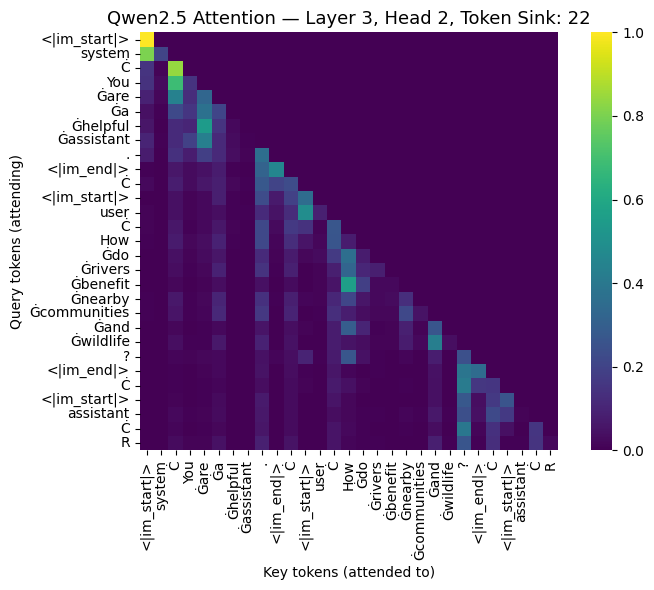

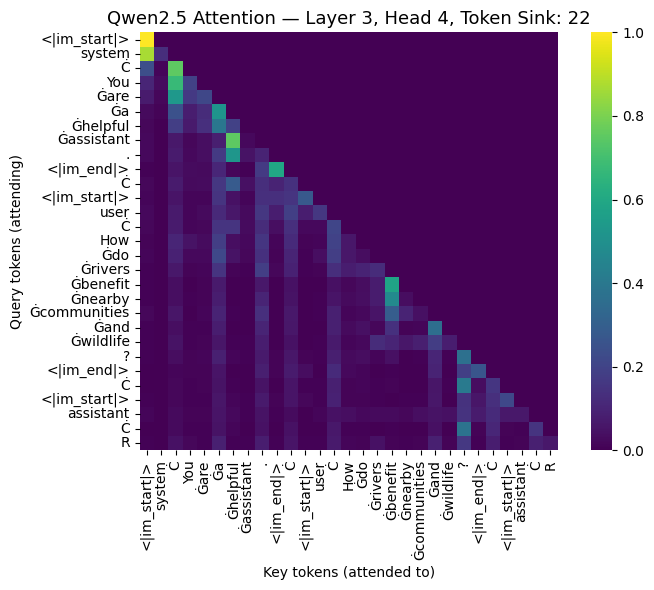

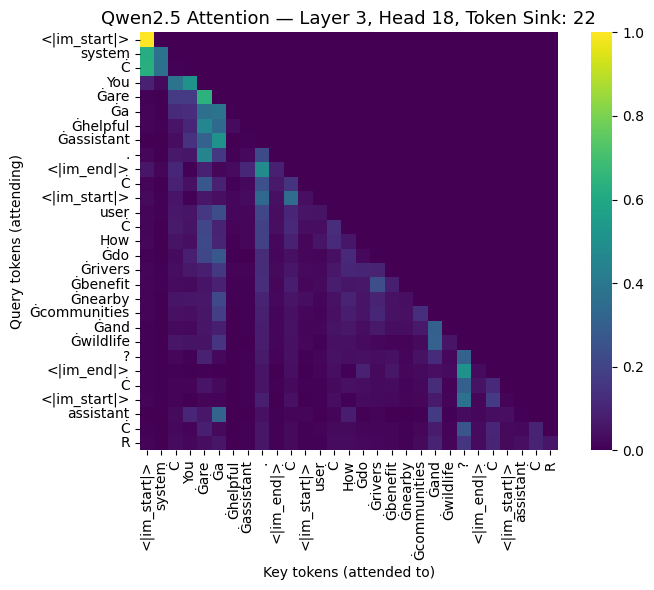

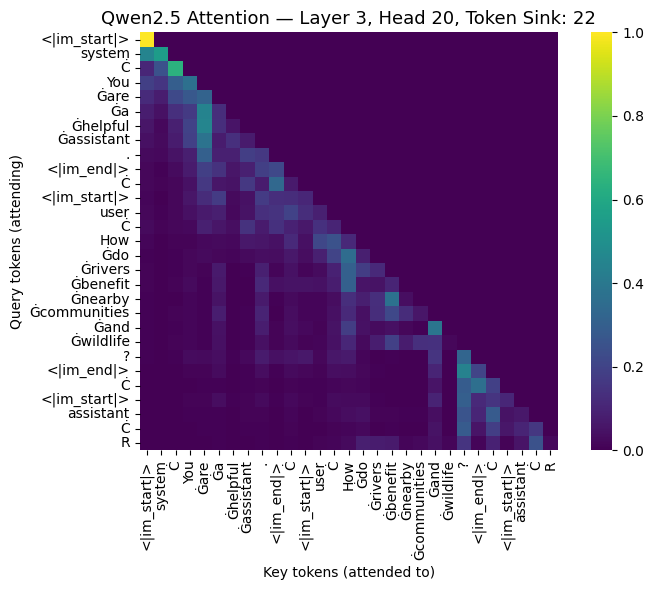

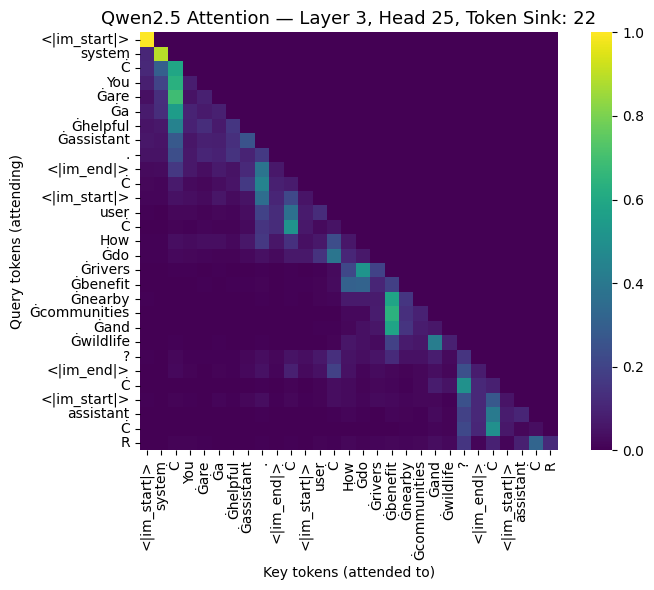

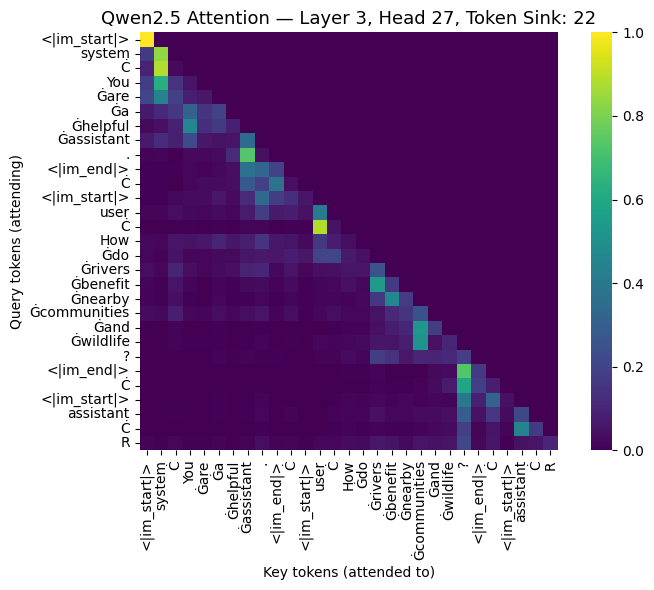

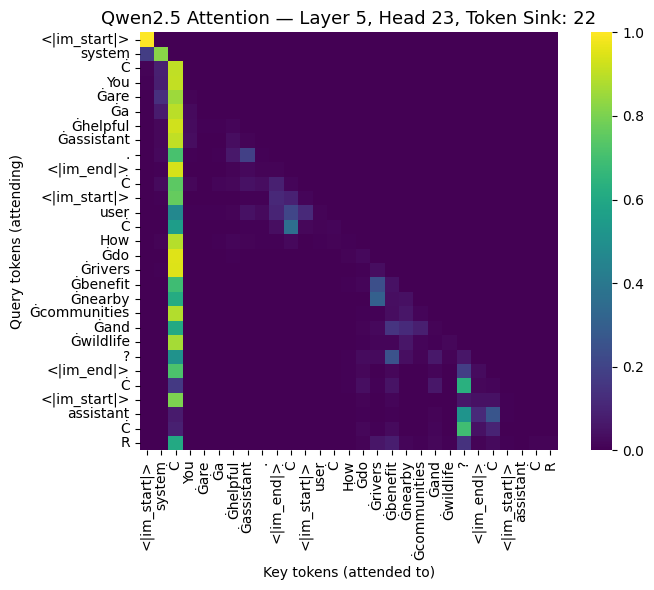

In [ ]:
plot_attention_heatmap(A, tokens, sink_mask, 22)

In [ ]:
stored_V = {}

def hook_value_attn(module, input, output):
  output_tensor = output
  stored_V["V"] = output_tensor.detach().clone()

hooks = model.model.layers[5].self_attn.v_proj.register_forward_hook(hook_value_attn)


In [ ]:
text = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nWhat is your favorite season, and why?<|im_end|>\n<|im_start|>assistant\nAs"
inp = tok(text, return_tensors="pt").to(model.device)

# Ask the model to return attention weights
with torch.no_grad():
  out = model(**inp, output_attentions=True, use_cache=False)




In [ ]:
stored_V["V"].shape

torch.Size([1, 29, 512])

In [ ]:
num_kv_heads = 4
num_q_heads = 28
group_size = 7

q_head = 23
kv_idx = q_head // group_size
head_dim = 128

In [ ]:
def patched_V_hook(module, input, output):
  """
  module: v_proj (Linear)
  input:  (hidden_states,)
  output: V: (batch, seq_len, hidden_size)

  Qwen uses GQA which means we have 28 query heads and then 4 KV heads
  Grouped Query Attention have query heads share kv heads, which is a lil annoying with patching.
  """

  V_target = output  # (B, T, D)
  # print(output.shape)
  V_source = stored_V["V"].to(V_target.device)
  B, T, D = V_target.shape
  V_target = V_target.view(B, T, num_kv_heads, head_dim)
  V_source = V_source.to(V_target.device).view(B, T, num_kv_heads, head_dim)

  t = 22       # token position
  kv_idx = 0   # mapped from q_head_idx = 13

  q_head = 23
  kv_idx = q_head // group_size

    # Patch KV head 1 at token position 7
  if T == 29:
    V_target[:, t, kv_idx, :] = V_source[:, t, kv_idx, :]

  else:
    pass

  V_patched = V_target.view(B, T, D)
  return V_patched



In [ ]:
hooks = model.model.layers[5].self_attn.v_proj.register_forward_hook(patched_V_hook)

In [ ]:
text = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHow do rivers benefit nearby communities and wildlife?<|im_end|>\n<|im_start|>assistant\nR"
inp = tok(text, return_tensors="pt").to(model.device)


In [ ]:
hooks.remove()

In [ ]:
import torch.nn.functional as F

def manual_generate_no_cache(model, tokenizer, prompt, max_new_tokens=50):
    model.eval()
    device = next(model.parameters()).device

    # Tokenize
    tokens = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = tokens["input_ids"]  # (1, T)

    for _ in range(max_new_tokens):
        # Full forward pass every step
        out = model(input_ids, use_cache=False)

        # Greedy next token
        next_token = out.logits[:, -1].argmax(dim=-1, keepdim=True)
        # logits_last = out.logits[:, -1, :]          # [B, V]
        # probs_last  = F.softmax(logits_last, dim=-1) # [B, V]

        # next_token = torch.argmax(logits_last, dim=-1, keepdim=True)  # [B, 1], dtype long
        # next_prob  = probs_last.gather(1, next_token)

        # Append
        input_ids = torch.cat([input_ids, next_token], dim=1)

        # Stop at eos
        if next_token.item() == tokenizer.eos_token_id:
            break

    return tokenizer.decode(input_ids[0])

In [ ]:
output = manual_generate_no_cache(model, tokenizer, "text", max_new_tokens = 1024)

In [ ]:
print(output)

pooppoo haha!! i!!!!! i!!!!!!!!!!!! i!!!!!!!!!!!!!!!!!! i!!!!!!!!!!! i!!!!!!!!!!!!!!!!!!!!!!!!! i!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
inp = tokenizer(output, return_tensors="pt")


In [ ]:
len(inp["input_ids"].tolist()[0])

142

In [ ]:
import gc
def clear_cache():
  torch.cuda.empty_cache()
  gc.collect()
  !nvidia-smi

In [ ]:
clear_cache()

Tue Dec  9 22:02:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             71W /  400W |   15179MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----